### Notebook to find variants of a genome mapped on the de Bruijn graph of a RPGG (RR PanGenome Graph)

In [2]:
%matplotlib notebook
import bioinformatics_functions as bio
import gzip
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict


## Interpret danbing-tk output with cigar strings:

In [242]:
def show_info(novel_kmers, k, histogram=False, elements=False):
    print("Number of possible reads with edits:", novel_kmers.reads)
    print()

    if novel_kmers.reads > 0:

        # print the elements from the dictionary:
        if elements:
            print('Canonical k-mers NOT in the graph:')
            for key in novel_kmers.d.keys():
                print(key, "    ", novel_kmers.d[key], "    ", bio.number_to_pattern(key, k))

        # print how often k-mer multiplicities appear:
        mylist = list(novel_kmers.d.values())
        print()
        print("Number of k-mer appearances:")
        mtp = defaultdict(int)
        for i in mylist:
            mtp[i] += 1
        for key in sorted(mtp.keys()):
            print(key, "  ", mtp[key])

        print()
        print("Total elements in dictionary = ", len(novel_kmers.d.keys()))

        # plot the histogram:

        #print(max(list(multiplicity_dict.values())))
        #print(list(multiplicity_dict.values()))
        if histogram:
            thresh = 2
            bins = np.arange(thresh+1,max(mylist)+2)-0.5
            mylist_array = np.array(mylist)
            plt.hist(mylist_array[mylist_array>thresh], bins=bins)
            plt.xlabel('Number of appearances')
            plt.ylabel('count')
            plt.show() 

            
class novel_kmers_dict:
    def __init__(self):
        self.d = defaultdict(int)
        self.reads = 0

# convert the region string into symbolic string
def region_to_symbolstring(region):
    number = list('0123456789')
    count = 0
    region_symbols = ''
    for i,el in enumerate(region):
        if el not in number:
            region_symbols += int(region[count:i])*el
            count = i+1
    return region_symbols

# check if the k-mer positions (indices) are in the flank or tandem repeat region
def check_region(indices, region, d_shift, include_flank_border):
    if indices:
        sub_region = region[indices[0]-d_shift:indices[-1]+1-d_shift]
        # first check if any . or * is in the region
        if sub_region.find('.')+sub_region.find('*') == -2:     # all TR region
            return indices
        elif sub_region.find('=') == -1:                        # no TR in region
            return list()
        else:                                                   # a mixture of regions with TR being present
            if sub_region.find('.') == -1:                      # TR and * --> use all
                return indices
            else:                                               # flank is present
                if include_flank_border:
                    # check if the flank region is to the left or to the right:
                    if sub_region.find('.') < sub_region.find('='): #left
                        return range(sub_region.rindex('.')+1+d_shift,indices[-1]+d_shift)
                    else:
                        return range(0+d_shift,sub_region.find('.')+d_shift)
                else:
                    return list()
        
    
def sort_kmer_in_dict(read, kmer_pos, k, novel_kmers):
    if len(kmer_pos) > 0: novel_kmers.reads +=1
    for i in kmer_pos:
        seq = read[i:i+k]
        # get the canonical kmer:
        seq_number = bio.canonical_to_number(seq)
#        seq_number = bio.pattern_to_number(seq)
        novel_kmers.d[seq_number] += 1 
    return novel_kmers
    
# create set of potential novel k-mer positions form read cigar string
def interpret_cigar(read, cigar, region, k, novel_kmers, indel=True, include_flank_border=False):
    
    region = region_to_symbolstring(region)
    l_region = len(region)
    
    symbol = list('ACTG=.*I')
    number = list('0123456789')
    TR = list('=')
    flank = list('.')
    unassigned = list('*')
    nucleotide = list('ACTG')

    kmer_pos = set()
    indices = list()
    count = 0
    d_shift = 0
    read_pos = 0
    
    for i,el in enumerate(cigar):
        if el in symbol:
            if (el in TR or el in flank or el in unassigned):
                noe = int(cigar[count:i])  # read number in cigar string
                read_pos = read_pos + noe        # position in read
                
            elif (el in nucleotide):
                if cigar[i-1] == 'X':
                    indices = range(max(read_pos+d_shift-(k-1),0),min(read_pos+d_shift+1, l_region))
                    indices = check_region(indices, region, d_shift, include_flank_border)
                    if indices:
                        kmer_pos |= set(indices)
                    read_pos += 1
                elif cigar[i-1] == 'D':
                    if indel:
                        indices = range(max(read_pos+d_shift-(k-1),0),min(read_pos+d_shift+1-1, l_region))
                        indices = check_region(indices, region, d_shift, include_flank_border)
                        if indices:
                            kmer_pos |= set(indices)
                    read_pos += 1
                    d_shift -= 1
            else:  # i.e. I
                indices = range(max(read_pos+d_shift-(k-1),0),min(read_pos+d_shift+1, l_region))
                if indices:
                    kmer_pos |= set(indices)
                read_pos += 1
            count = i+1

    novel_kmers = sort_kmer_in_dict(read, kmer_pos, k, novel_kmers)
    return novel_kmers

def read_file(file, k, indel, include_flank_border, n):
    novel_kmers = novel_kmers_dict()
    cnt = 0

    with gzip.open(file, 'rt') as f:
        for line in f:
#            if cnt == n-1:
            if cnt > -1:
#                print(line)
                # forward strand
                read = line.split()[3]
                cigar = line.split()[5]
                region = line.split()[6]
                novel_kmers = interpret_cigar(read, cigar, region, k, novel_kmers, indel, include_flank_border)
 #               print(read)
 #               print(cigar)
 #               print(region)
        
                # reverse strand:
                read = line.split()[4]
                cigar = line.split()[7]
                region = line.split()[8]
                novel_kmers = interpret_cigar(read, cigar, region, k, novel_kmers, indel, include_flank_border)
                
            cnt = cnt + 1
    return novel_kmers
    
        


Number of possible reads with edits: 243


Number of k-mer appearances:
1    2215
2    630
3    173
4    48
5    34
6    32
7    24
8    26
9    18
10    3
11    2
12    2
14    1
15    4
16    3
19    3
20    3
21    3
22    6
24    3
25    2
26    2
28    3
29    1
30    1
31    2
32    5
33    2
36    1

Total elements in dictionary =  3252


<IPython.core.display.Javascript object>


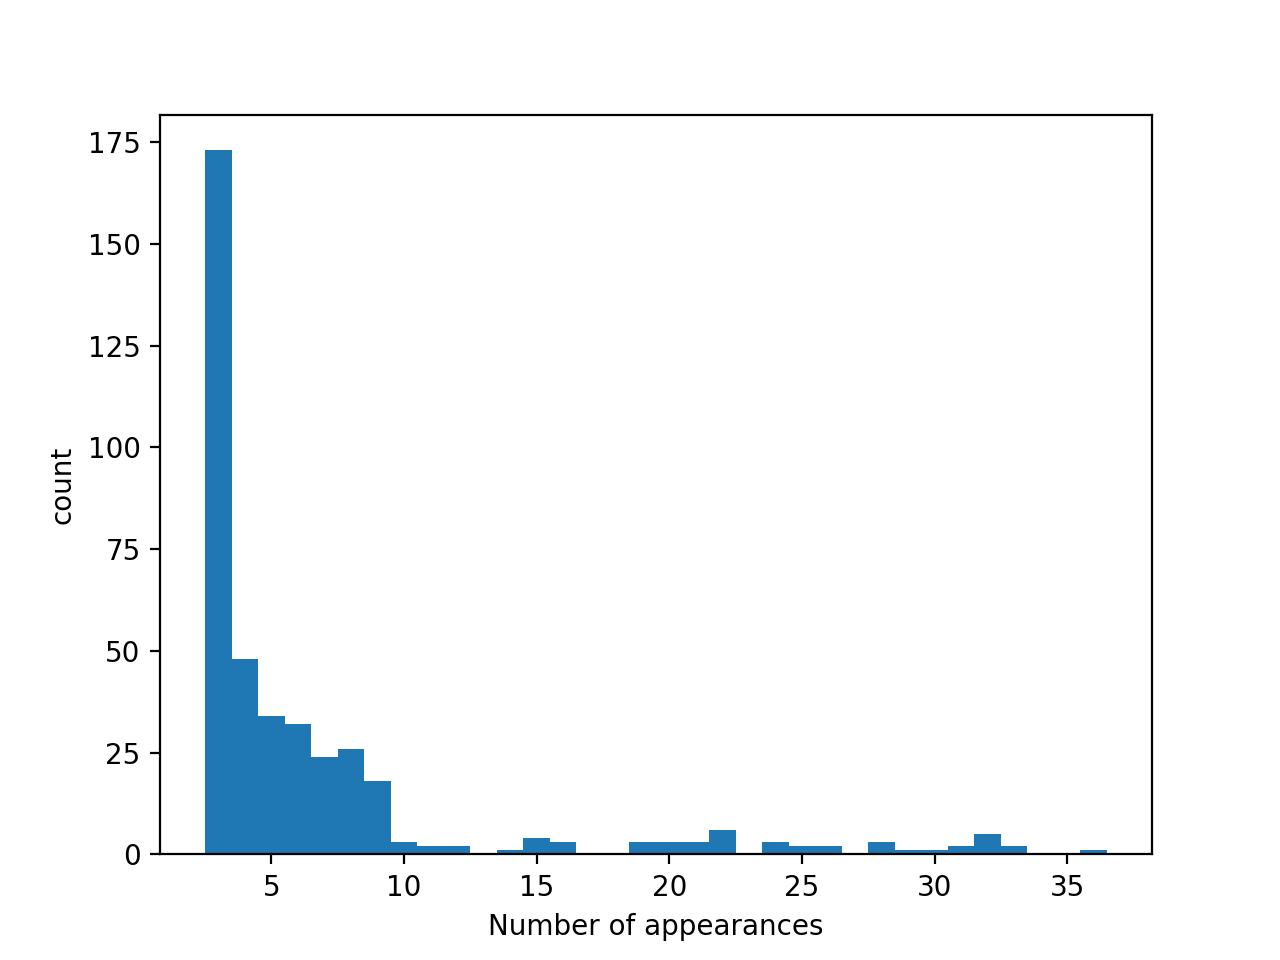

In [243]:
k = 21
path = '/Users/tkroll/Dropbox/uni_dropbox/Courses/bioinformatics_USC/rare_variants/rare_var_cigar_strings/output/'
file = '175.err.1bpindel.aln.gz'

n=47
novel_kmers = read_file(path+file, k, indel=True, include_flank_border=True, n=n)
show_info(novel_kmers, k, histogram=True, elements=False)


In [209]:
k=4
#cigar='2=XA5=XC7=XC2='
read = 'ACGTATTTCGTGCTA'
cigar='5=DA5=DA5='
region = '7.7='

k=21
read='GATGCCCGAGAAGACAGGGGGTGGCGGAGATCTTCAGAGAGAGGATGCCCGAGAAGACAGGCGGTGGTGGAGATCTTCAGAGAGAGGACGCCTGAGAAGCCAGGCGGTGGCGGAGATCTTCAGAAAGAAAGCCCAGAGTTCCATAGTGGG'
cigar='18=DC81=XA50='
region='105=26='

novel_kmers = novel_kmers_dict()
novel_kmers = interpret_cigar(read, cigar, region, k, novel_kmers, indel = True)   
show_info(novel_kmers, k, histogram=False, elements=True)    


Number of possible reads with edits: 1

Canonical k-mers NOT in the graph:
2445321310890      1      GATGCCCGAGAAGACAGGGGG
985192221355      1      ATGCCCGAGAAGACAGGGGGT
3940768885422      1      TGCCCGAGAAGACAGGGGGTG
2568936008378      1      GCCCGAGAAGACAGGGGGTGG
1479651011305      1      CCCGAGAAGACAGGGGGTGGC
1520557534118      1      CCGAGAAGACAGGGGGTGGCG
1684183625370      1      CGAGAAGACAGGGGGTGGCGG
2338687990376      1      GAGAAGACAGGGGGTGGCGGA
558658939298      1      AGAAGACAGGGGGTGGCGGAG
2234635757192      1      GAAGACAGGGGGTGGCGGAGA
142450006563      1      AAGACAGGGGGTGGCGGAGAT
569800026253      1      AGACAGGGGGTGGCGGAGATC
2279200105015      1      GACAGGGGGTGGCGGAGATCT
320707397855      1      ACAGGGGGTGGCGGAGATCTT
1282829591421      1      CAGGGGGTGGCGGAGATCTTC
733271854580      1      AGGGGGTGGCGGAGATCTTCA
2933087418322      1      GGGGGTGGCGGAGATCTTCAG
2936256651080      1      GGGGTGGCGGAGATCTTCAGA
2345729909257      1      GAGAGAGGACGCCTGAGAAGC
586826614821      1